In [2]:
import tensorflow as tf

print( "Tensorflow version: ", tf.__version__ )
print( "KERAS version: ", tf.keras.__version__ )

import os
import numpy as np

import matplotlib.pyplot as plt
import scipy.signal
import pickle
import h5py
from tqdm import trange

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

WIN_SIZE = 80

Tensorflow version:  2.4.0
KERAS version:  2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3595483016024159817
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15476363136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18170838476488339399
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 6fe4:00:00.0, compute capability: 7.0"
]


In [3]:
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Concatenate, Add, Lambda, Flatten
from tensorflow.keras.models import Model


def create_model( w=80, conv_channels=[32,32,32,16] ):
    
    input_data = Input( shape=(w,w,1),dtype=tf.float32 )
    
    l_ = Conv2D(conv_channels[0], kernel_size=3, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), padding="same", use_bias=True, activation="relu", name="C0")(input_data)
    l_ = MaxPooling2D( pool_size=2, name="M0" )( l_ )
    
    l_ = Conv2D(conv_channels[1], kernel_size=3, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), padding="same", use_bias=True, activation="relu", name="C1")(l_)
    l_ = MaxPooling2D( pool_size=2, name="M1" )( l_ )
    
    l_ = Conv2D(conv_channels[2], kernel_size=3, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), padding="same", use_bias=True, activation="relu", name="C2")(l_)
    l_ = MaxPooling2D( pool_size=2, name="M2" )( l_ )
    
    l_ = Conv2D(conv_channels[3], kernel_size=3, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), padding="same", use_bias=True, activation="relu", name="C3")(l_)
    l_ = MaxPooling2D( pool_size=2, name="M3" )( l_ )
    topl_ = Flatten()(l_)
            
    # Feature probability
    #l_ = Dense(16, use_bias=True, activation="relu", name="D1")( topl_ )
    featprobl_ = Dense(1, use_bias=True, activation="sigmoid", name="featprob")( topl_ )
    
    # Displacement
    l_ = Dense(16, use_bias=True, activation="relu", name="D2")( topl_ )
    displ_ = Dense(2, use_bias=True, activation="tanh", name="disp")( l_ )
    
    # Eccentricity
    l_ = Dense(8, use_bias=True, activation="relu", name="D3")( topl_ )
    ecc_ = Dense(1, use_bias=True, activation="sigmoid", name="ecc")( l_ )
    
    # Peak-value
    l_ = Dense(8, use_bias=True, activation="relu", name="D4")( topl_ )
    peak_ = Dense(1, use_bias=True, activation="relu", name="peak")( l_ )
    
    # Alpha-vec
    l_ = Dense(16, use_bias=True, activation="relu", name="D5")( topl_ )
    alpha_v_ = Dense(2, use_bias=True, activation="linear", name="alphav")( l_ )
    #alpha_v_ /= tf.norm(alpha_v_, axis=1)    
    
    out = Concatenate()( [featprobl_,displ_,ecc_,peak_,alpha_v_] )
    model = Model(inputs=input_data, outputs=out, trainable=True, name="MODEL1DOT" )
    return model


with tf.Graph().as_default():
    model = create_model()
    print( model.summary())
    

Model: "MODEL1DOT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
C0 (Conv2D)                     (None, 80, 80, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
M0 (MaxPooling2D)               (None, 40, 40, 32)   0           C0[0][0]                         
__________________________________________________________________________________________________
C1 (Conv2D)                     (None, 40, 40, 32)   9248        M0[0][0]                         
__________________________________________________________________________________________

In [3]:
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error , kullback_leibler_divergence

def prob_loss( yTrue, yPred ):
    return tf.reduce_mean( binary_crossentropy( yTrue[:,0], yPred[:,0]  ) )

def disp_loss( yTrue, yPred ):
    mask = tf.cast( yTrue[:,0]>0.5, tf.float32 )
    return tf.reduce_mean( mask * tf.sqrt( tf.square( yTrue[:,1]-yPred[:,1] ) + tf.square( yTrue[:,2]-yPred[:,2] ) ) )

def ecc_loss( yTrue, yPred ):
    mask = tf.cast( yTrue[:,0]>0.5, tf.float32 )
    return tf.reduce_mean( tf.abs( mask*(yTrue[:,3]-yPred[:,3]) ) ) 

def peak_loss( yTrue, yPred ):
    mask = tf.cast( yTrue[:,0]>0.5, tf.float32 )
    return tf.reduce_mean( tf.abs( mask*(yTrue[:,4]-yPred[:,4]) ) ) 

def alpha_v_loss( yTrue, yPred ):
    alpha_v_ =  yPred[:,5:]
    alpha_v_ /= (tf.norm( alpha_v_, axis=1, keepdims=True )+1E-8)
    return tf.reduce_mean( tf.abs( alpha_v_ - yTrue[:,5:] ) )
    
def accuracy( yTrue, yPred):     
    pred_yes = tf.cast( yPred[:,0]>0.8, dtype=tf.float32 )
    gt_yes = tf.cast( yTrue[:,0]>0.8, dtype=tf.float32 )
    
    true_positive = tf.reduce_sum( pred_yes * gt_yes )
    true_negative =  tf.reduce_sum( (1-pred_yes) * (1-gt_yes) )
    num_values = tf.reduce_sum(yTrue[:,0]*0 + 1)
    return ( true_positive+true_negative  ) / num_values

def false_positives( yTrue, yPred):
    pred_yes = tf.cast( yPred[:,0]>0.8, dtype=tf.float32 )
    gt_no = tf.cast( yTrue[:,0]<0.8, dtype=tf.float32 )
    false_positive = tf.reduce_sum( pred_yes * gt_no )
    return false_positive

def false_negatives( yTrue, yPred):
    pred_no = tf.cast( yPred[:,0]<0.8, dtype=tf.float32 )
    gt_yes = tf.cast( yTrue[:,0]>0.8, dtype=tf.float32 )
    false_negative = tf.reduce_sum( pred_no * gt_yes )
    return false_negative

def lossfun( yTrue, yPred, alpha=1.0, beta=1.0, gamma=1.0, delta=1.0/250.0, phi=1.0 ):
    aux = alpha*prob_loss( yTrue, yPred ) + beta*disp_loss( yTrue, yPred) + gamma*ecc_loss(yTrue, yPred) + delta*peak_loss(yTrue, yPred) + phi*alpha_v_loss(yTrue, yPred)
    
    return aux

In [4]:
def train_model( model, batch_size=32, learning_rate = 1E-3, decay_rate = 0.0, epochs = 20):

    rop = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                                               patience=2, min_lr=1E-6, verbose=1)

    history = tf.keras.callbacks.History()

    with h5py.File("../data/dots_100K_train.h5",'r') as f:
        x_train = f["x"]
        y_train = f["y"]
        print(x_train.shape)
        model.compile( loss=lossfun, 
                      optimizer=tf.keras.optimizers.Adam( learning_rate=learning_rate ),# epsilon=1E-4 ), 
                      metrics=[prob_loss, disp_loss, ecc_loss, peak_loss, alpha_v_loss, accuracy, false_positives, false_negatives] )
                      
        model.fit( x = x_train,
                 y = y_train,
                 batch_size = batch_size,
                 shuffle = "batch",
                 epochs=epochs,
                 callbacks=[history,rop], #[rop, early_stop, tboardcb, checkpoint],
                 verbose=1)
        
    return model

# Train full model

In [ ]:
with tf.Graph().as_default():
    model = create_model(WIN_SIZE)
    model = train_model( model, batch_size=128, learning_rate = 1E-3, decay_rate = 0.0, epochs = 70)

In [ ]:
with tf.Graph().as_default():
    model_json = model.to_json()

    model.save_weights("../data/last_dotmodel_trained.h5")
    print("Model weights saved.")

    with open("../data/last_dotmodel_trained.json", "w") as json_file:
        json_file.write(model_json)  
        print("Model saved to disk") 

# Evaluation

In [14]:
%reload_ext autoreload
%autoreload 1
%aimport dots_model_evaluator

from dots_model_evaluator import evaluate_dataset
    
with tf.Graph().as_default():
    model = create_model(WIN_SIZE)
    model.load_weights( "../data/last_dotmodel_trained.h5" )
    evaluate_dataset("../data/dots_10K_test.h5", model, WIN_SIZE, model_name="MODEL1DOT", saveplots=True)

/home/bergamasco/miniconda3/envs/connect2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Confusion matrix (%):
=-=-=-=-=-=-=-=-=-=-=-
                         Yes       No   <-    Predicted peak 
Actual peak  Yes  >    49.0300     0.0100
              No  >    0.0000     50.9600

 Accuracy: 0.99990
Precision: 1.00000
   Recall: 0.99980


# Pruning

In [5]:
import functools

def compute_convolutions_output( model, nsamples=-1 ):
    conv_outputs = [ layer.output for layer in model.layers if layer.name[0]=="C" ]
    conv_outputs = conv_outputs[:-1] # last convolution layer cannot be used because we have no next layer to update accordingly
    print("Model contains %d known convolution layers (named like C0,C1,etc.)"%len(conv_outputs))
    model_with_all_outputs = Model(inputs=model.input, outputs=conv_outputs)
    # Do some prediction
    nsamples = 3
    with h5py.File("../data/dots_10K_test.h5",'r') as f:
        x_test = np.array( f["x"] )
        y_test = np.array( f["y"] )
        print("Predicting...", end="")
        conv_layers_outputs = model_with_all_outputs.predict( x_test[0:nsamples,...] )
        print("Done!")
        
    return conv_layers_outputs


def estimate_optimal_channel_to_remove( all_convlayers_output, doplots=True, verbose=True ):
    
    scores = []
    
    for kk in range(len(all_convlayers_output)):
        convlayer_output = all_convlayers_output[kk]
        #print("Layer %d has %d channels: "%(kk, convlayer_output.shape[-1]))
        #print("----------------------------")
        mean_activation = np.mean(convlayer_output,axis=0)
        
        minscore = 999
        minchannel = None

        for ii in range( mean_activation.shape[-1] ):

            activation_mscore= np.amax(  mean_activation[:,:,ii] )-np.amin(  mean_activation[:,:,ii] )
            
            q98 = np.quantile( mean_activation[:,:,ii], 0.98 ) # 98th percentile
            q02 = np.quantile( mean_activation[:,:,ii], 0.02 ) # 2nd percentile
            activation_qscore = q98-q02
            
            scores.append( (activation_qscore,activation_mscore,kk,ii) )
            
            if verbose:
                #print("Channel %02d, qscore=%3.4f, mscore=%3.4f"%(ii,activation_qscore, activation_mscore) )
                pass
            
            if doplots:
                plt.figure( figsize=(3,2) )
                plt.plot( mean_activation[:,ii])
                plt.title("Mean channel %d activation. qscore=%3.4f, mscore=%3.4f"%(ii,activation_qscore,activation_mscore))

    #print("----------------------------") 
    def score_comp( a, b ):
        if a[0] == b[0]:
            if a[1]==b[1]:
                return 0
            return -1 if a[1]<b[1] else 1
        return -1 if a[0]<b[0] else 1
    
    scores_sorted = sorted( scores, key=functools.cmp_to_key( score_comp ) )
    #print("scores: ")
    #print(scores_sorted)
    return scores_sorted[0][3], scores_sorted[0][2], (scores_sorted[0][0]==0 and scores_sorted[0][1]==0)# Channel, Layer, lossless



def prune_channel( weights_file, layer, channel_to_remove ):
    conv_r = "C%d"%layer
    conv_rnext = "C%d"%(layer+1)
    tqdm.tqdm.write("Removing channel %d from layer %d (%s)"%(channel_to_remove,layer,conv_r) )
    with h5py.File(weights_file,'r+') as f:
        
        gname = list(f["/%s"%conv_r].keys())[0]
        
        kernel_dataset = "/%s/%s/kernel:0"%(conv_r,gname)
        bias_dataset = "/%s/%s/bias:0"%(conv_r,gname)

        gname = list(f["/%s"%conv_rnext].keys())[0]
        
        kernel_next_dataset = "/%s/%s/kernel:0"%(conv_rnext,gname)
        bias_next_dataset = "/%s/%s/bias:0"%(conv_rnext,gname)

        tqdm.tqdm.write("kernel dataset: %s"%kernel_dataset)
        tqdm.tqdm.write("bias dataset: %s"%bias_dataset)
        
        tqdm.tqdm.write("next kernel dataset: %s"%kernel_next_dataset)
        tqdm.tqdm.write("next bias dataset: %s"%bias_next_dataset)
        
        orig_kernels = np.array( f[kernel_dataset] )
        orig_bias = np.array( f[bias_dataset] )

        orig_kernels_next = np.array( f[kernel_next_dataset] )
        orig_bias_next = np.array( f[bias_next_dataset] )

        #tqdm.tqdm.write( str(orig_kernels.shape) )
        #tqdm.tqdm.write( str(orig_bias.shape) )
        #tqdm.tqdm.write( str(orig_kernels_next.shape) )
        #tqdm.tqdm.write( str(orig_bias_next.shape) )

        tqdm.tqdm.write("After pruning:")

        orig_kernels_pruned = np.concatenate( ( orig_kernels[:,:,:,:channel_to_remove], orig_kernels[:,:,:,channel_to_remove+1:] ), axis=-1 )
        orig_bias_pruned = np.concatenate( ( orig_bias[:channel_to_remove], orig_bias[channel_to_remove+1:] ), axis=-1 )

        orig_kernels_next_pruned = np.concatenate( ( orig_kernels_next[:,:,:channel_to_remove,:], orig_kernels_next[:,:,channel_to_remove+1:,:] ), axis=2 )

        #tqdm.tqdm.write( str(orig_kernels_pruned.shape) )
        #tqdm.tqdm.write( str(orig_bias_pruned.shape) )
        #tqdm.tqdm.write( str(orig_kernels_next_pruned.shape) )

        del( f[kernel_dataset] )
        f.create_dataset(kernel_dataset, data=orig_kernels_pruned )
        del( f[bias_dataset] )
        f.create_dataset(bias_dataset, data=orig_bias_pruned )
        del( f[kernel_next_dataset] )
        f.create_dataset(kernel_next_dataset, data=orig_kernels_next_pruned )
    tqdm.tqdm.write("Done!")
    
    
# TEST 
#with tf.Graph().as_default():
#    model = create_model(WIN_SIZE, conv_channels)
#    model.load_weights("../data/dot_pruned.h5")#
#
#    conv_outputs = compute_convolutions_output(model, nsamples=-1 )
#    channel_to_remove, layer, lossless = estimate_optimal_channel_to_remove( conv_outputs, doplots=False, verbose=False )
#    prune_channel("../data/dot_pruned.h5", layer, channel_to_remove)

In [6]:
conv_channels=[32,32,32,16]
weight_data = "../data/last_dotmodel_trained.h5"

import pickle
import shutil
import tqdm
import sys
from tensorflow.keras import backend as K

shutil.copyfile(weight_data, "../data/dot_pruned.h5")
pickle.dump( conv_channels, open("../data/dot_conv_channels.pickle","wb"))

In [7]:
evaluation_data = [];
    
model = None
for numprune in tqdm.tqdm(range(64), file=sys.stdout):
    conv_channels = pickle.load( open("../data/dot_conv_channels.pickle","rb"))
    print("Iteration ",numprune)
    print("Conv_channels: ",conv_channels)
    K.clear_session()

    with tf.Graph().as_default():
        model = create_model(WIN_SIZE, conv_channels)
        model.load_weights("../data/dot_pruned.h5")

        from dots_model_evaluator import evaluate_dataset
        evaluation_data.append( evaluate_dataset( "../data/dots_10K_test.h5", model, WIN_SIZE, drawplots = False, verbose=False ) )

        conv_outputs = compute_convolutions_output(model, nsamples=-1 )
        channel_to_remove, layer, lossless = estimate_optimal_channel_to_remove( conv_outputs, doplots=False, verbose=False )

    tqdm.tqdm.write("Best channel to remove: %d from layer %d. Lossless? %d"%(channel_to_remove,layer,lossless) )
    prune_channel("../data/dot_pruned.h5", layer, channel_to_remove)
    conv_channels[layer] -= 1

    if not lossless:
        tqdm.tqdm.write("Retrain needed")
        with tf.Graph().as_default():
            model = create_model(WIN_SIZE, conv_channels)
            model.load_weights("../data/dot_pruned.h5")
            
            model = train_model( model, batch_size=128, learning_rate = 1E-5, decay_rate = 0.0, epochs = 3)
            
            tqdm.tqdm.write("Done! saving new weights...")
            model.save_weights("../data/dot_pruned_new.h5")
            shutil.copyfile( "../data/dot_pruned_new.h5", "../data/dot_pruned.h5" )
    else:
        tqdm.tqdm.write("No retrain needed")

    pickle.dump( conv_channels, open("../data/dot_conv_channels.pickle","wb"))

print("Pruning completed.")

  0%|          | 0/64 [00:00<?, ?it/s]Iteration  0
Conv_channels:  [32, 32, 32, 16]


/home/bergamasco/miniconda3/envs/connect2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Model contains 3 known convolution layers (named like C0,C1,etc.)
Predicting...Done!
Best channel to remove: 24 from layer 0. Lossless? 1
Removing channel 24 from layer 0 (C0) 
kernel dataset: /C0/C0/kernel:0       
bias dataset: /C0/C0/bias:0           
next kernel dataset: /C1/C1/kernel:0  
next bias dataset: /C1/C1/bias:0      
After pruning:                        
Done!                                 
No retrain needed                     
  2%|▏         | 1/64 [00:14<15:25, 14.69s/it]Iteration  1
Conv_channels:  [31, 32, 32, 16]
Model contains 3 known convolution layers (named like C0,C1,etc.)
Predicting...Done!
Best channel to remove: 28 from layer 0. Lossless? 1
Removing channel 28 from layer 0 (C0)         
kernel dataset: /C0/C0/kernel:0               
bias dataset: /C0/C0/bias:0                   
next kernel dataset: /C1/C1/kernel:0          
next bias dataset: /C1/C1/bias:0              
After pruning:                                
Done!                                 

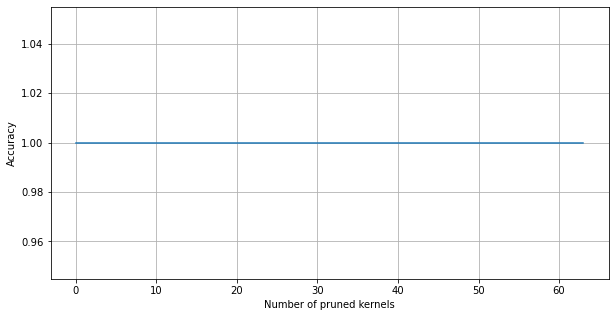

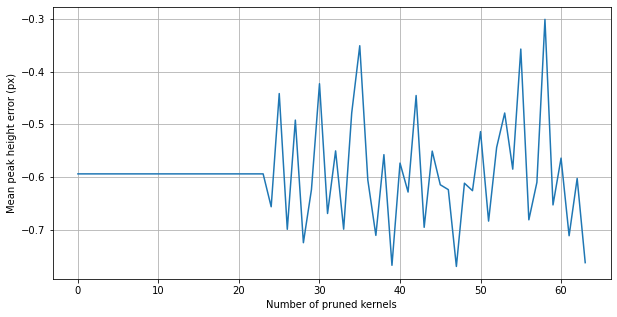

In [13]:
d = np.array( evaluation_data )
xvals = np.arange( d.shape[0])

plt.figure( figsize=(10,5))
plt.plot(xvals, d[:,0])
plt.grid("minor")
plt.ylabel("Accuracy")
plt.xlabel("Number of pruned kernels")
plt.savefig("accuracy_vs_pruning.png")

plt.figure( figsize=(10,5))
plt.errorbar(xvals, d[:,1])
plt.grid("minor")
plt.ylabel("Mean Peak position error (px)")
plt.xlabel("Number of pruned kernels")
plt.savefig("position_error_vs_pruning.png")

plt.figure( figsize=(10,5))
plt.errorbar(xvals, d[:,3])
plt.grid("minor")
plt.ylabel("Mean eccentricity error (px)")
plt.xlabel("Number of pruned kernels")
plt.savefig("eccentricity_error_vs_pruning.png")

plt.figure( figsize=(10,5))
plt.errorbar(xvals, d[:,5])
plt.grid("minor")
plt.ylabel("Mean peak height error (px)")
plt.xlabel("Number of pruned kernels")
plt.savefig("height_error_vs_pruning.png")

In [14]:
with tf.Graph().as_default():
    conv_channels = pickle.load( open("../data/dot_conv_channels.pickle","rb"))
    with tf.Graph().as_default():
        model = create_model(WIN_SIZE, conv_channels)
        model.load_weights("../data/dot_pruned.h5")
        
        model_json = model.to_json()
        model.save_weights("../data/last_dotmodel_pruned.h5")
        print("Pruned model weights saved.")

        with open("../data/last_dotmodel_pruned.json", "w") as json_file:
            json_file.write(model_json)  
            print("Model saved to disk") 

Pruned model weights saved.
Model saved to disk


Loading model weights
Model: "MODEL1DOT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
C0 (Conv2D)                     (None, 80, 80, 7)    70          input_1[0][0]                    
__________________________________________________________________________________________________
M0 (MaxPooling2D)               (None, 40, 40, 7)    0           C0[0][0]                         
__________________________________________________________________________________________________
C1 (Conv2D)                     (None, 40, 40, 9)    576         M0[0][0]                         
____________________________________________________________________

/home/bergamasco/miniconda3/envs/connect2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Confusion matrix (%):
=-=-=-=-=-=-=-=-=-=-=-
                         Yes       No   <-    Predicted peak 
Actual peak  Yes  >    49.0300     0.0100
              No  >    0.0000     50.9600

 Accuracy: 0.99990
Precision: 1.00000
   Recall: 0.99980
Confusion matrix (%):
=-=-=-=-=-=-=-=-=-=-=-
                         Yes       No   <-    Predicted peak 
Actual peak  Yes  >    49.0300     0.0100
              No  >    0.0000     50.9600

 Accuracy: 0.99990
Precision: 1.00000
   Recall: 0.99980


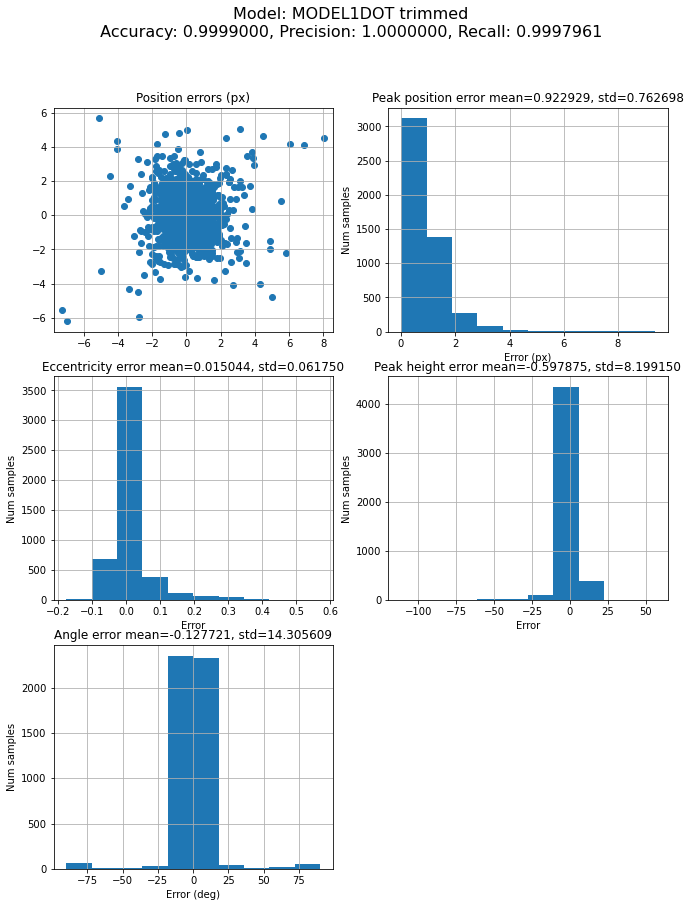

In [4]:
%reload_ext autoreload
%autoreload 1
%aimport dots_model_evaluator

from dots_model_evaluator import evaluate_dataset

with tf.Graph().as_default():
    from tensorflow.keras.models import model_from_json
    model = None
    with open("../data/last_dotmodel_pruned.json", "r") as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)

    print("Loading model weights")
    model.load_weights("../data/last_dotmodel_pruned.h5")

    model.summary()
    #plot_model( model )

    evaluate_dataset( "../data/dots_10K_test.h5", model, WIN_SIZE, saveplots=True )
    evaluate_dataset("../data/dots_10K_test.h5", model, WIN_SIZE, model_name="MODEL1DOT trimmed", saveplots=True)